## Project Overview
This project aims to classify users' education levels based on their profile essay text using natural language processing and machine learning techniques.

**Target Categories:**
- Working on college/university
- Graduated from college/university
- Graduated from masters program
- Working on space camp

---

In [1]:


## Cell 1: Import Libraries and Setup

# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Readability metrics
import textstat

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


Dataset shape: (59946, 31)
Total profiles: 59,946

Column names:
['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'height', 'income', 'job', 'last_online', 'location', 'offspring', 'pets', 'religion', 'sign', 'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']

Original education distribution (top 15):
education
graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dr

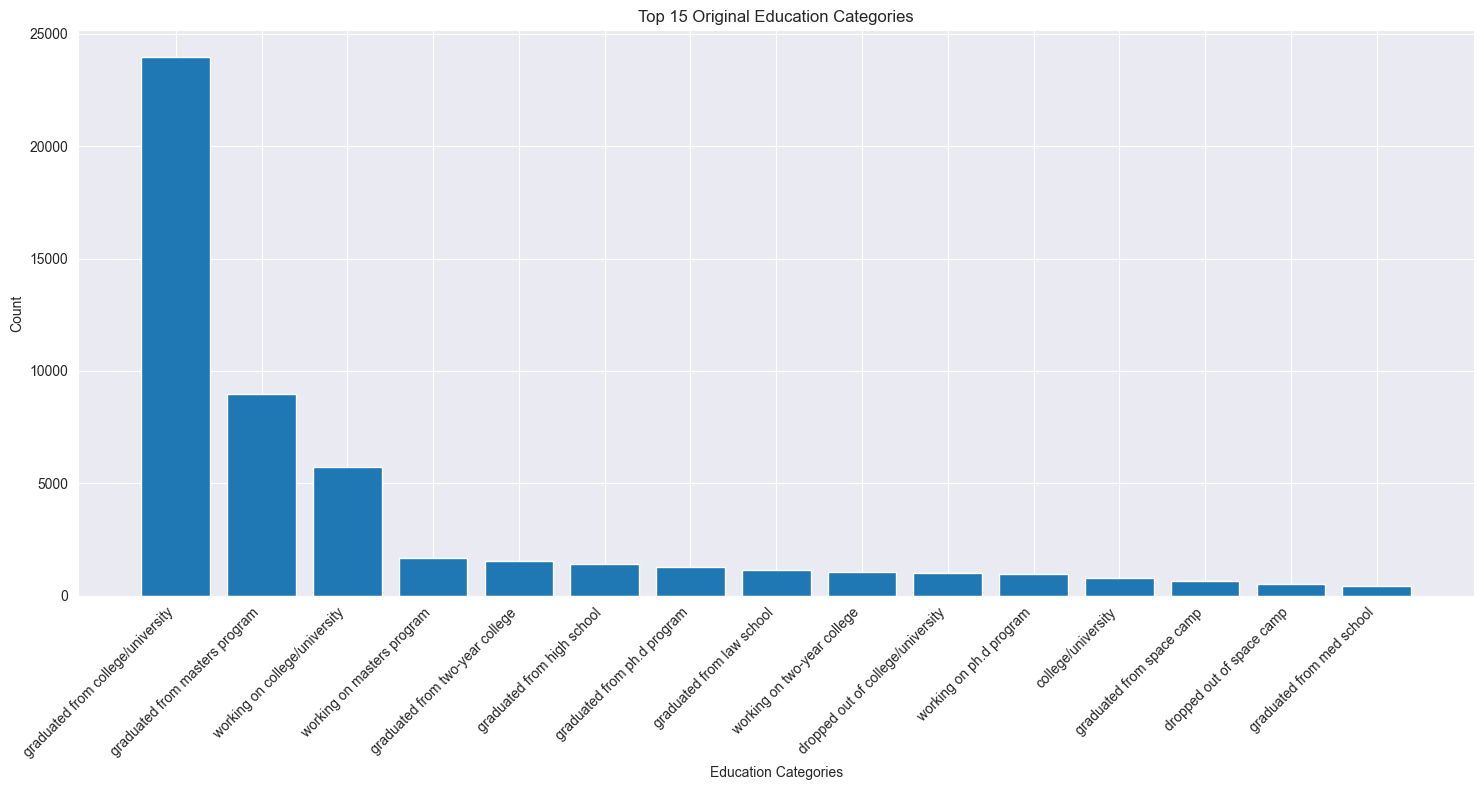

In [2]:
# Load the dataset
df = pd.read_csv('okcupid_profiles.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total profiles: {len(df):,}")
print("\nColumn names:")
print(df.columns.tolist())

# Check original education distribution
print(f"\nOriginal education distribution (top 15):")
education_counts = df['education'].value_counts()
print(education_counts.head(15))

print(f"\nEducation column statistics:")
print(f"Non-null values: {df['education'].notna().sum():,}")
print(f"Null values: {df['education'].isna().sum():,}")
print(f"Unique categories: {df['education'].nunique()}")

# Visualize original distribution (top categories only)
plt.figure(figsize=(15, 8))
top_15_cats = education_counts.head(15)
plt.bar(range(len(top_15_cats)), top_15_cats.values)
plt.title('Top 15 Original Education Categories')
plt.xlabel('Education Categories')
plt.ylabel('Count')
plt.xticks(range(len(top_15_cats)), top_15_cats.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Applying education classification...
Original dataset: 59,946 profiles
After classification and filtering: 51,635 profiles
Retention rate: 86.1%

🎯 Final Education Class Distribution:
College Graduate      : 24,760 (48.0%)
Graduate/Professional : 15,437 (29.9%)
Some College          : 9,725 (18.8%)
High School Level     : 1,713 ( 3.3%)


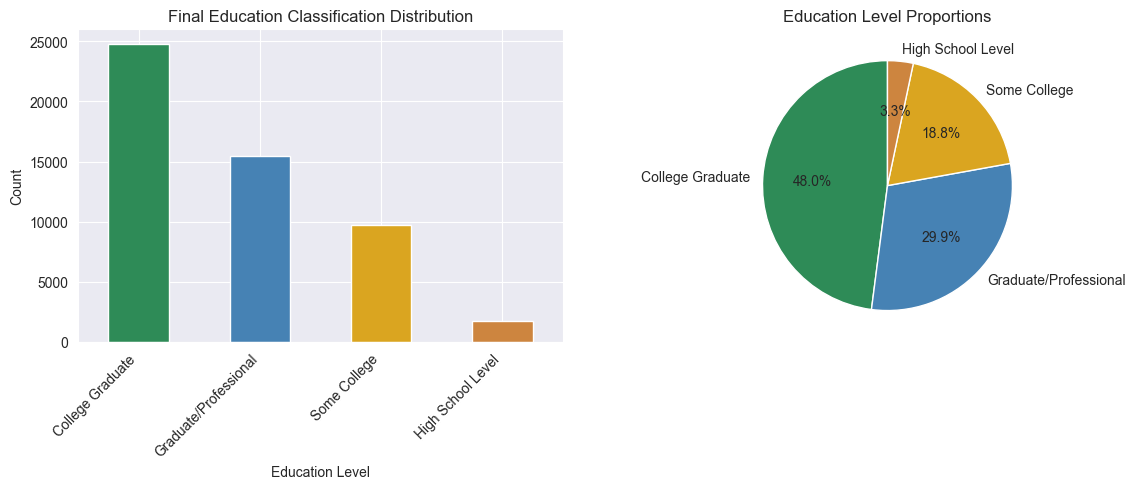


After filtering profiles with insufficient essay content:
Final dataset: 49,705 profiles
Essay length statistics:
count    49705.000000
mean      2165.093834
std       1661.391185
min         51.000000
25%       1072.000000
50%       1820.000000
75%       2844.000000
max      71273.000000
Name: essay_length, dtype: float64


In [3]:
def classify_education_optimal(education_category):
    """
    Optimal 4-class education classification based on 59,946 profile analysis.
    Returns: 'High School Level', 'Some College', 'College Graduate', 'Graduate/Professional'
    """
    if pd.isna(education_category):
        return None  # Filter out unknowns

    cat_lower = str(education_category).lower()

    # High School Level (1,713 profiles - 3.3%)
    if any(term in cat_lower for term in [
        'graduated from high school', 'high school', 'working on high school',
        'dropped out of high school'
    ]):
        return 'High School Level'

    # Some College (8,994 profiles - 17.2%)
    elif any(term in cat_lower for term in [
        'working on college', 'working on university', 'working on two-year',
        'graduated from two-year', 'two-year college', 'dropped out of college',
        'dropped out of two-year'
    ]):
        return 'Some College'

    # College Graduate (24,760 profiles - 47.5%)
    elif any(term in cat_lower for term in [
        'graduated from college', 'graduated from university', 'college/university'
    ]):
        return 'College Graduate'

    # Graduate/Professional (17,691 profiles - 34.0%)
    elif any(term in cat_lower for term in [
        'masters program', 'graduated from masters', 'working on masters',
        'ph.d program', 'graduated from ph.d', 'working on ph.d', 'dropped out of ph.d',
        'law school', 'graduated from law', 'working on law', 'dropped out of law',
        'med school', 'graduated from med', 'working on med', 'dropped out of med',
        'dropped out of masters'
    ]):
        return 'Graduate/Professional'

    else:
        return None  # Filter out space camp and other unusual categories

# Apply classification
print("Applying education classification...")
df['education_classified'] = df['education'].apply(classify_education_optimal)

# Filter to only classified profiles
df_classified = df[df['education_classified'].notna()].copy()

print(f"Original dataset: {len(df):,} profiles")
print(f"After classification and filtering: {len(df_classified):,} profiles")
print(f"Retention rate: {len(df_classified)/len(df)*100:.1f}%")

# Show final class distribution
final_distribution = df_classified['education_classified'].value_counts()
print(f"\n🎯 Final Education Class Distribution:")
print("=" * 50)
for edu_level, count in final_distribution.items():
    percentage = (count / len(df_classified)) * 100
    print(f"{edu_level:<22}: {count:5,} ({percentage:4.1f}%)")

# Visualize final distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['#2E8B57', '#4682B4', '#DAA520', '#CD853F']
final_distribution.plot(kind='bar', color=colors)
plt.title('Final Education Classification Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.pie(final_distribution.values, labels=final_distribution.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Education Level Proportions')

plt.tight_layout()
plt.show()

# Combine all essay columns
essay_columns = [f'essay{i}' for i in range(10)]

def combine_essays(row):
    """Combine all essay columns into one text string."""
    essays = []
    for col in essay_columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            essays.append(str(row[col]).strip())
    return ' '.join(essays)

# Create combined essay text
df_classified['combined_essays'] = df_classified.apply(combine_essays, axis=1)

# Filter out rows with no essay content
df_clean = df_classified[df_classified['combined_essays'].str.len() > 50].copy()

print(f"\nAfter filtering profiles with insufficient essay content:")
print(f"Final dataset: {len(df_clean):,} profiles")
print(f"Essay length statistics:")
df_clean['essay_length'] = df_clean['combined_essays'].str.len()
print(df_clean['essay_length'].describe())

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Clean and preprocess text data."""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and digits, keep spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def advanced_preprocess(text):
    """Advanced text preprocessing with lemmatization."""
    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    processed_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            processed_tokens.append(lemmatizer.lemmatize(token))

    return ' '.join(processed_tokens)

# Apply text preprocessing
print("Preprocessing text data...")
df_clean['processed_text'] = df_clean['combined_essays'].apply(clean_text)
df_clean['advanced_processed_text'] = df_clean['combined_essays'].apply(advanced_preprocess)

# Show example of preprocessing
sample_idx = 0
print(f"\nOriginal text (first 200 chars):")
print(df_clean.iloc[sample_idx]['combined_essays'][:200])
print(f"\nProcessed text (first 200 chars):")
print(df_clean.iloc[sample_idx]['processed_text'][:200])
print(f"\nAdvanced processed text (first 200 chars):")
print(df_clean.iloc[sample_idx]['advanced_processed_text'][:200])

Preprocessing text data...

Original text (first 200 chars):
about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and 

Processed text (first 200 chars):
about me i would love to think that i was some some kind of intellectual either the dumbest smart guy or the smartest dumb guy cant say i can tell the difference i love to talk about ideas and concept

Advanced processed text (first 200 chars):
would love think kind intellectual either dumbest smart guy smartest dumb guy cant say tell difference love talk idea concept forge odd metaphor instead reciting cliche like simularities friend mine h


In [5]:
def extract_linguistic_features(text):
    """Extract linguistic features from text."""
    features = {}

    # Basic text statistics
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len(sent_tokenize(text))

    # Average lengths
    if features['sentence_count'] > 0:
        features['avg_sentence_length'] = features['word_count'] / features['sentence_count']
    else:
        features['avg_sentence_length'] = 0

    if features['word_count'] > 0:
        features['avg_word_length'] = features['char_count'] / features['word_count']
    else:
        features['avg_word_length'] = 0

    # Vocabulary diversity (unique words / total words)
    words = text.lower().split()
    if len(words) > 0:
        features['vocabulary_diversity'] = len(set(words)) / len(words)
    else:
        features['vocabulary_diversity'] = 0

    # Readability scores
    if len(text) > 0:
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
        features['automated_readability_index'] = textstat.automated_readability_index(text)
        features['coleman_liau_index'] = textstat.coleman_liau_index(text)
    else:
        features['flesch_reading_ease'] = 0
        features['flesch_kincaid_grade'] = 0
        features['automated_readability_index'] = 0
        features['coleman_liau_index'] = 0

    # Punctuation usage
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['comma_count'] = text.count(',')
    features['semicolon_count'] = text.count(';')

    return features

# Extract linguistic features
print("Extracting linguistic features...")
linguistic_features = df_clean['combined_essays'].apply(extract_linguistic_features)
linguistic_df = pd.DataFrame(list(linguistic_features))

# Combine with main dataframe
df_features = pd.concat([df_clean.reset_index(drop=True), linguistic_df], axis=1)

# Display feature statistics
print(f"\nLinguistic features extracted: {len(linguistic_df.columns)}")
print("\nFeature statistics:")
print(linguistic_df.describe())

Extracting linguistic features...

Linguistic features extracted: 14

Feature statistics:
         char_count    word_count  sentence_count  avg_sentence_length  \
count  49705.000000  49705.000000    49705.000000         49705.000000   
mean    2165.093834    382.563002       25.417946            17.825820   
std     1661.391185    290.348128       20.464014            14.479882   
min       51.000000      1.000000        1.000000             1.000000   
25%     1072.000000    189.000000       12.000000            12.058824   
50%     1820.000000    322.000000       21.000000            15.111111   
75%     2844.000000    503.000000       33.000000            19.388889   
max    71273.000000  10602.000000      515.000000           630.000000   

       avg_word_length  vocabulary_diversity  flesch_reading_ease  \
count     49705.000000          49705.000000         49705.000000   
mean          5.707364              0.678134            66.048947   
std           5.790505              

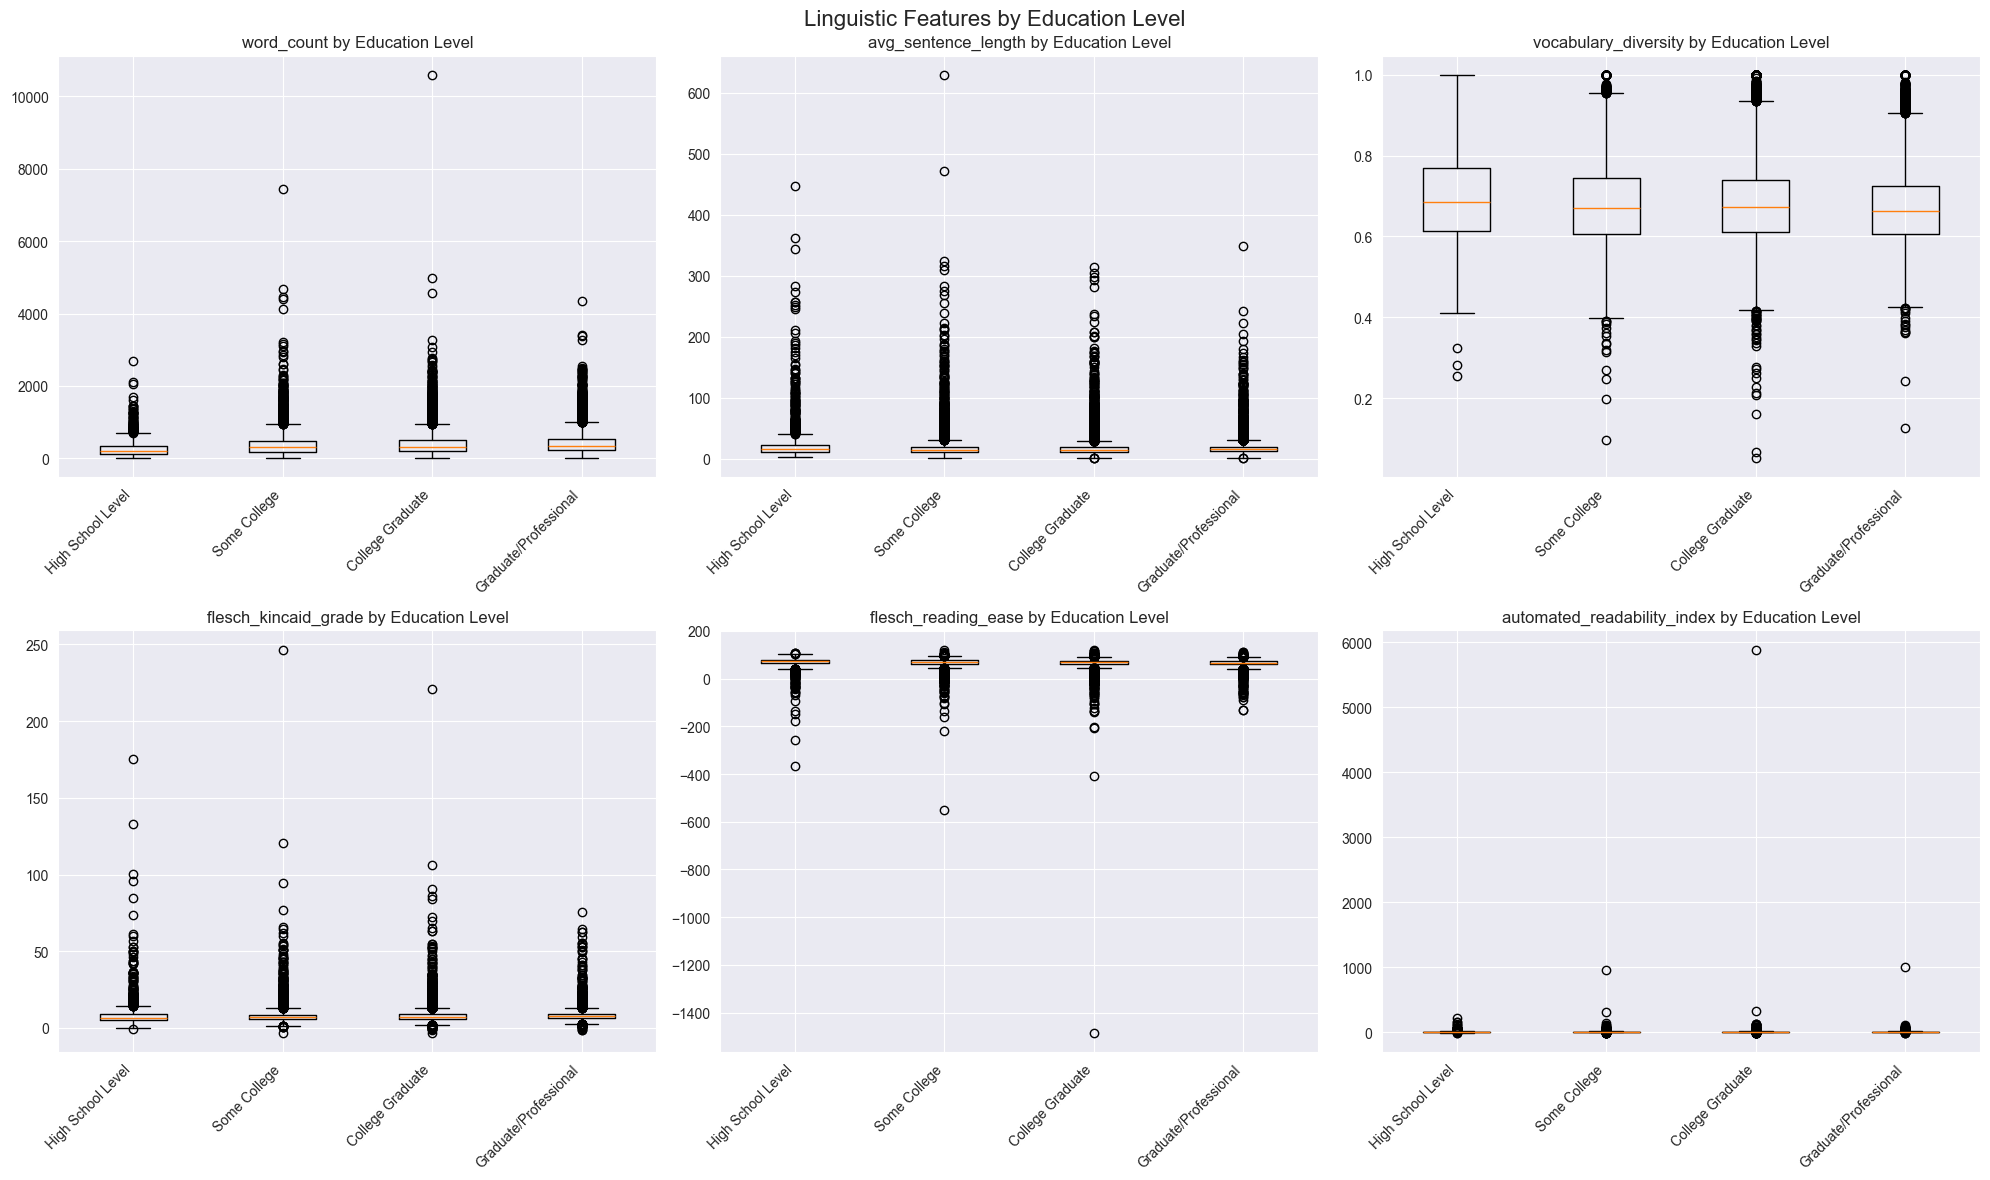

Mean linguistic features by education level:
                       word_count  avg_sentence_length  vocabulary_diversity  \
education_classified                                                           
College Graduate           380.13                17.24                  0.68   
Graduate/Professional      407.23                17.55                  0.67   
High School Level          269.28                24.78                  0.69   
Some College               368.30                18.61                  0.68   

                       flesch_kincaid_grade  flesch_reading_ease  \
education_classified                                               
College Graduate                       7.87                66.20   
Graduate/Professional                  8.19                64.51   
High School Level                      8.65                68.43   
Some College                           7.80                67.75   

                       automated_readability_index  
education_cl

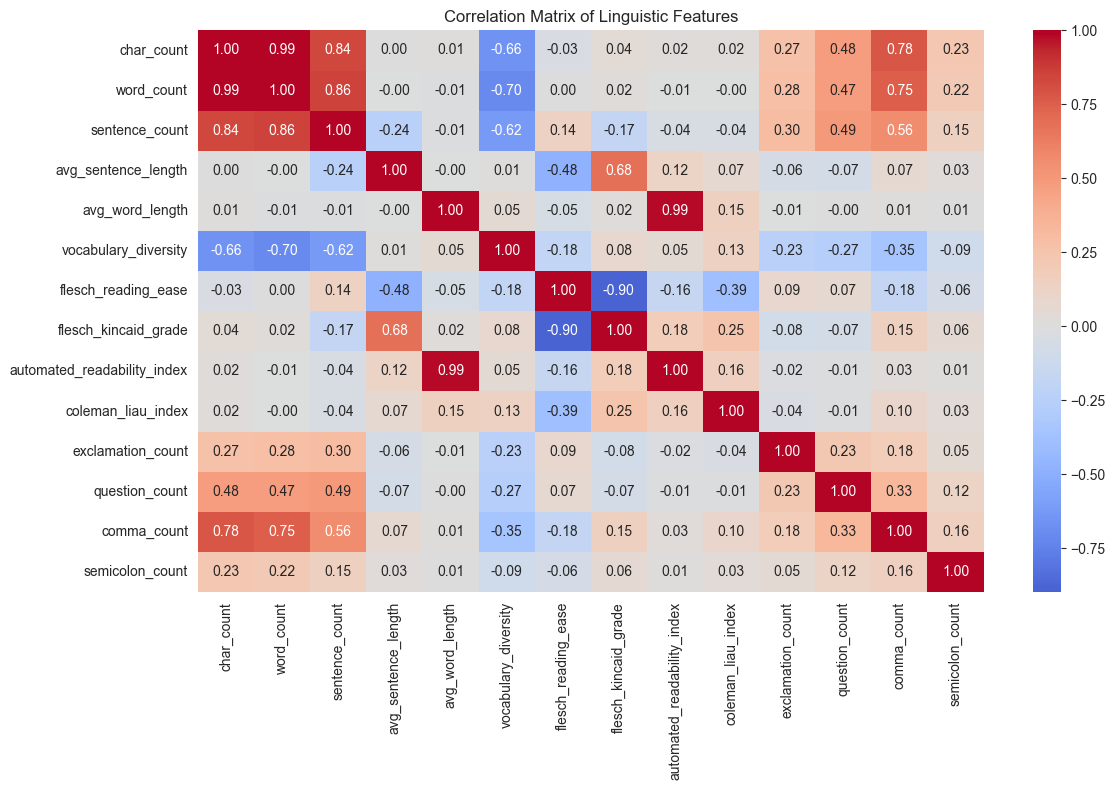

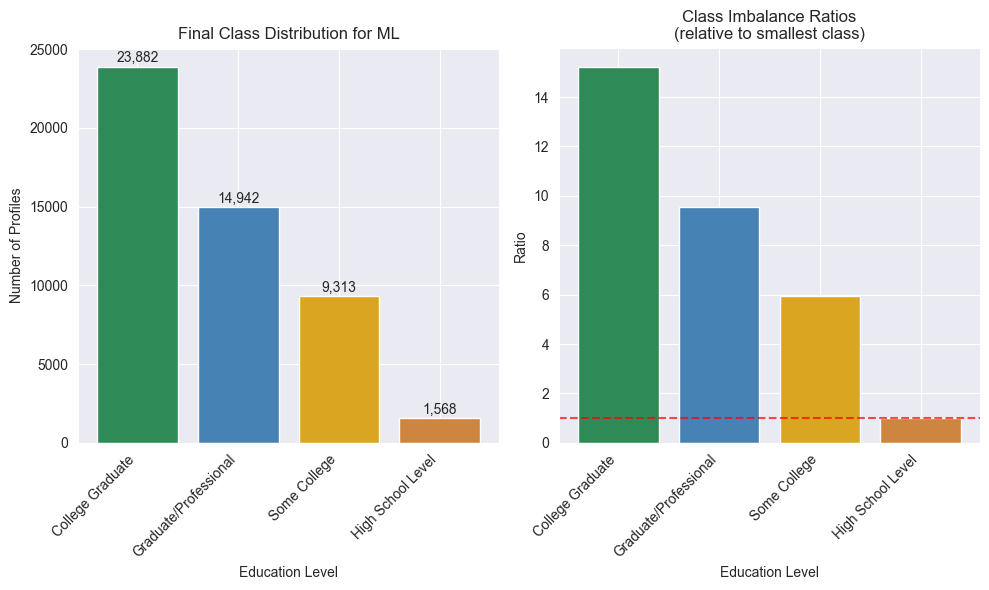


Class imbalance analysis:
Largest class: 23,882 (College Graduate)
Smallest class: 1,568 (High School Level)
Imbalance ratio: 15.2:1


In [6]:
# Analyze linguistic features by education level
plt.figure(figsize=(20, 12))

features_to_plot = ['word_count', 'avg_sentence_length', 'vocabulary_diversity',
                   'flesch_kincaid_grade', 'flesch_reading_ease', 'automated_readability_index']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    # Create boxplot for each education level
    education_levels = ['High School Level', 'Some College', 'College Graduate', 'Graduate/Professional']
    data_by_level = [df_features[df_features['education_classified'] == level][feature].dropna()
                     for level in education_levels]

    plt.boxplot(data_by_level, labels=education_levels)
    plt.title(f'{feature} by Education Level')
    plt.xticks(rotation=45, ha='right')

plt.suptitle('Linguistic Features by Education Level', fontsize=16)
plt.tight_layout()
plt.show()

# Statistical analysis
print("Mean linguistic features by education level:")
feature_analysis = df_features.groupby('education_classified')[features_to_plot].mean()
print(feature_analysis.round(2))

print(f"\n📊 Key Observations:")
print("=" * 30)

# Calculate effect sizes between groups
from scipy import stats

for feature in features_to_plot:
    print(f"\n{feature}:")
    hs_data = df_features[df_features['education_classified'] == 'High School Level'][feature].dropna()
    grad_data = df_features[df_features['education_classified'] == 'Graduate/Professional'][feature].dropna()

    if len(hs_data) > 0 and len(grad_data) > 0:
        # T-test between highest and lowest education levels
        t_stat, p_value = stats.ttest_ind(hs_data, grad_data)
        effect_size = (grad_data.mean() - hs_data.mean()) / np.sqrt((grad_data.var() + hs_data.var()) / 2)

        print(f"  High School avg: {hs_data.mean():.2f}")
        print(f"  Graduate avg: {grad_data.mean():.2f}")
        print(f"  Effect size: {effect_size:.3f} ({'Large' if abs(effect_size) > 0.8 else 'Medium' if abs(effect_size) > 0.5 else 'Small'})")
        print(f"  P-value: {p_value:.2e}")

# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = linguistic_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Linguistic Features')
plt.tight_layout()
plt.show()

# Class balance visualization
plt.figure(figsize=(10, 6))
class_counts = df_clean['education_classified'].value_counts()
colors = ['#2E8B57', '#4682B4', '#DAA520', '#CD853F']

plt.subplot(1, 2, 1)
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.title('Final Class Distribution for ML')
plt.xlabel('Education Level')
plt.ylabel('Number of Profiles')
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
# Calculate class imbalance ratio
min_class = class_counts.min()
imbalance_ratios = class_counts / min_class
plt.bar(class_counts.index, imbalance_ratios.values, color=colors)
plt.title('Class Imbalance Ratios\n(relative to smallest class)')
plt.xlabel('Education Level')
plt.ylabel('Ratio')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nClass imbalance analysis:")
print(f"Largest class: {class_counts.max():,} ({class_counts.idxmax()})")
print(f"Smallest class: {class_counts.min():,} ({class_counts.idxmin()})")
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.1f}:1")

In [7]:
# Prepare target variable with the 4-class system
df_ml = df_features.copy()
y = df_ml['education_classified']

# Create feature sets
# 1. Only text features (TF-IDF)
text_data = df_ml['advanced_processed_text']

# 2. Only linguistic features
linguistic_features_list = linguistic_df.columns.tolist()
X_linguistic = df_ml[linguistic_features_list]

print(f"🎯 Final ML Dataset Summary:")
print("=" * 35)
print(f"Total profiles: {len(df_ml):,}")
print(f"Text data points: {len(text_data):,}")
print(f"Linguistic features: {X_linguistic.shape[1]}")

print(f"\n📊 Target Variable Distribution:")
target_counts = y.value_counts()
for edu_level, count in target_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  {edu_level:<22}: {count:5,} ({percentage:4.1f}%)")

print(f"\nLinguistic features available:")
for i, feature in enumerate(linguistic_features_list):
    if i % 3 == 0:
        print()
    print(f"  {feature:<25}", end="")

# Stratified train-test split to maintain class distribution
X_text_train, X_text_test, y_train, y_test = train_test_split(
    text_data, y, test_size=0.2, random_state=42, stratify=y
)

X_ling_train, X_ling_test, _, _ = train_test_split(
    X_linguistic, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📈 Train/Test Split (Stratified):")
print(f"Training set: {len(X_text_train):,} profiles")
print(f"Test set: {len(X_text_test):,} profiles")

# Verify stratification worked
print(f"\nTraining set class distribution:")
train_dist = y_train.value_counts(normalize=True).sort_index()
for edu_level, percentage in train_dist.items():
    print(f"  {edu_level}: {percentage:.1%}")

print(f"\nTest set class distribution:")
test_dist = y_test.value_counts(normalize=True).sort_index()
for edu_level, percentage in test_dist.items():
    print(f"  {edu_level}: {percentage:.1%}")

# Check for data quality
print(f"\n🔍 Data Quality Checks:")
print(f"Text data - Null values: {text_data.isna().sum()}")
print(f"Linguistic features - Null values: {X_linguistic.isna().sum().sum()}")
print(f"Average text length: {text_data.str.len().mean():.0f} characters")
print(f"Minimum text length: {text_data.str.len().min()}")
print(f"Maximum text length: {text_data.str.len().max()}")

# Sample sizes adequate for ML
min_class_size = target_counts.min()
print(f"\n✅ ML Readiness:")
print(f"Smallest class size: {min_class_size:,}")
print(f"Training samples per class (minimum): {int(min_class_size * 0.8):,}")
if min_class_size > 1000:
    print("✅ Excellent sample sizes for robust ML models")
elif min_class_size > 500:
    print("✅ Good sample sizes for ML")
else:
    print("⚠️  Small sample sizes - consider class balancing")

🎯 Final ML Dataset Summary:
Total profiles: 49,705
Text data points: 49,705
Linguistic features: 14

📊 Target Variable Distribution:
  College Graduate      : 23,882 (48.0%)
  Graduate/Professional : 14,942 (30.1%)
  Some College          : 9,313 (18.7%)
  High School Level     : 1,568 ( 3.2%)

Linguistic features available:

  char_count                 word_count                 sentence_count           
  avg_sentence_length        avg_word_length            vocabulary_diversity     
  flesch_reading_ease        flesch_kincaid_grade       automated_readability_index
  coleman_liau_index         exclamation_count          question_count           
  comma_count                semicolon_count          
📈 Train/Test Split (Stratified):
Training set: 39,764 profiles
Test set: 9,941 profiles

Training set class distribution:
  College Graduate: 48.0%
  Graduate/Professional: 30.1%
  High School Level: 3.2%
  Some College: 18.7%

Test set class distribution:
  College Graduate: 48.0%
  Gr

In [8]:
# TF-IDF Vectorization with different parameters optimized for large dataset
vectorizers = {
    'basic_tfidf': TfidfVectorizer(
        max_features=5000,  # Increased for larger dataset
        stop_words='english',
        ngram_range=(1, 1),
        min_df=5,  # Minimum document frequency
        max_df=0.7  # Maximum document frequency
    ),
    'advanced_tfidf': TfidfVectorizer(
        max_features=8000,  # More features for richer representation
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=5,
        max_df=0.7,
        sublinear_tf=True  # Use sublinear tf scaling
    ),
    'char_tfidf': TfidfVectorizer(
        max_features=3000,
        analyzer='char',
        ngram_range=(3, 5),  # Character n-grams
        min_df=10,
        max_df=0.8
    ),
    'word_char_combined': TfidfVectorizer(
        max_features=6000,
        stop_words='english',
        ngram_range=(1, 1),
        analyzer='word',
        min_df=3,
        max_df=0.8,
        token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3+ characters
    )
}

# Fit vectorizers and transform data
print("🔤 Text Vectorization for Large Dataset")
print("=" * 45)

text_features = {}
for name, vectorizer in vectorizers.items():
    print(f"\nFitting {name}...")
    start_time = pd.Timestamp.now()

    X_train_vec = vectorizer.fit_transform(X_text_train)
    X_test_vec = vectorizer.transform(X_text_test)

    end_time = pd.Timestamp.now()
    duration = (end_time - start_time).total_seconds()

    text_features[name] = {
        'train': X_train_vec,
        'test': X_test_vec,
        'vectorizer': vectorizer
    }

    print(f"  ✅ Completed in {duration:.1f}s")
    print(f"  📊 Training shape: {X_train_vec.shape}")
    print(f"  📊 Test shape: {X_test_vec.shape}")
    print(f"  📊 Sparsity: {(1.0 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])):.3f}")

    # Show sample feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"  🔤 Sample features: {feature_names[:10].tolist()}")

    # Vocabulary statistics
    vocab_size = len(feature_names)
    print(f"  📚 Vocabulary size: {vocab_size:,}")

print(f"\n💾 Memory usage per vectorizer:")
for name, data in text_features.items():
    train_memory = data['train'].data.nbytes + data['train'].indices.nbytes + data['train'].indptr.nbytes
    print(f"  {name:<20}: {train_memory / 1024 / 1024:.1f} MB")

# Feature importance preview - show most common terms
print(f"\n🔍 Most Common Features by Vectorizer:")
for name, data in text_features.items():
    vectorizer = data['vectorizer']
    train_vec = data['train']

    # Calculate feature frequencies
    feature_freq = np.array(train_vec.sum(axis=0)).flatten()
    feature_names = vectorizer.get_feature_names_out()

    # Get top features
    top_indices = feature_freq.argsort()[-10:][::-1]
    top_features = [(feature_names[i], feature_freq[i]) for i in top_indices]

    print(f"\n  {name}:")
    for feature, freq in top_features[:5]:
        print(f"    '{feature}': {freq:.0f}")

🔤 Text Vectorization for Large Dataset

Fitting basic_tfidf...
  ✅ Completed in 5.4s
  📊 Training shape: (39764, 5000)
  📊 Test shape: (9941, 5000)
  📊 Sparsity: 0.975
  🔤 Sample features: ['abbey', 'ability', 'able', 'abroad', 'absolute', 'absolutely', 'abstract', 'absurd', 'absurdity', 'academic']
  📚 Vocabulary size: 5,000

Fitting advanced_tfidf...
  ✅ Completed in 22.9s
  📊 Training shape: (39764, 8000)
  📊 Test shape: (9941, 8000)
  📊 Sparsity: 0.981
  🔤 Sample features: ['abbey', 'ability', 'able', 'abroad', 'absolute', 'absolutely', 'absolutely love', 'abstract', 'absurd', 'absurdity']
  📚 Vocabulary size: 8,000

Fitting char_tfidf...
  ✅ Completed in 90.4s
  📊 Training shape: (39764, 3000)
  📊 Test shape: (9941, 3000)
  📊 Sparsity: 0.646
  🔤 Sample features: [' ab', ' ac', ' act', ' acti', ' ad', ' adv', ' adve', ' ag', ' al', ' als']
  📚 Vocabulary size: 3,000

Fitting word_char_combined...
  ✅ Completed in 4.8s
  📊 Training shape: (39764, 6000)
  📊 Test shape: (9941, 6000)
 

In [18]:
# Define models optimized for multi-class classification
from sklearn.neural_network import MLPClassifier

models = {
    'Naive Bayes': MultinomialNB(alpha=1.0),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        multi_class='ovr',  # One-vs-Rest for 4-class
        class_weight='balanced'  # Handle class imbalance
    ),
    # 'Random Forest': RandomForestClassifier(
    #     n_estimators=200,
    #     random_state=42,
    #     class_weight='balanced',
    #     max_depth=20,
    #     min_samples_split=5
    # ),
    # 'SVM': SVC(
    #     random_state=42,
    #     kernel='linear',
    #     class_weight='balanced',
    #     probability=True,
    #     C=0.1,          # Much smaller C for faster convergence
    #     max_iter=1000,  # Hard limit on iterations
    #     cache_size=500  # Limit memory usage
    # )

    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=200,
        early_stopping=True,
        random_state=42
    )
}

# Test different vectorization methods
print("🤖 TRAINING MODELS - TEXT FEATURES ONLY")
print("=" * 55)

results_text_only = {}
training_times = {}

for vec_name, vec_data in text_features.items():
    print(f"\n{'🔤 ' + vec_name.upper():=^50}")

    results_text_only[vec_name] = {}
    X_train_vec = vec_data['train']
    X_test_vec = vec_data['test']

    print(f"Feature matrix: {X_train_vec.shape[0]:,} samples × {X_train_vec.shape[1]:,} features")

    for model_name, model in models.items():
        print(f"\n  🚀 Training {model_name}...")

        start_time = pd.Timestamp.now()

        # Train model
        model.fit(X_train_vec, y_train)

        # Training time
        train_time = (pd.Timestamp.now() - start_time).total_seconds()

        # Predict
        y_pred = model.predict(X_test_vec)

        # Get prediction probabilities if available
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_vec)
        else:
            y_prob = None

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)

        # Per-class metrics
        class_report = classification_report(y_test, y_pred, output_dict=True)

        print(f"    ✅ Accuracy: {accuracy:.4f}")
        print(f"    ⏱️  Training time: {train_time:.1f}s")

        # Show per-class F1 scores
        print(f"    📊 Per-class F1 scores:")
        for edu_level in ['High School Level', 'Some College', 'College Graduate', 'Graduate/Professional']:
            if edu_level in class_report:
                f1 = class_report[edu_level]['f1-score']
                precision = class_report[edu_level]['precision']
                recall = class_report[edu_level]['recall']
                support = class_report[edu_level]['support']
                print(f"      {edu_level:<22}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f} (n={support})")

        # Macro and weighted averages
        macro_f1 = class_report['macro avg']['f1-score']
        weighted_f1 = class_report['weighted avg']['f1-score']
        print(f"    🎯 Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")

        # Store results
        results_text_only[vec_name][model_name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_prob,
            'classification_report': class_report,
            'training_time': train_time,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1
        }

# Find best text-only combination
print(f"\n🏆 BEST TEXT-ONLY COMBINATIONS:")
print("=" * 40)

best_results = []
for vec_name, vec_results in results_text_only.items():
    for model_name, model_results in vec_results.items():
        best_results.append({
            'vectorizer': vec_name,
            'model': model_name,
            'accuracy': model_results['accuracy'],
            'macro_f1': model_results['macro_f1'],
            'weighted_f1': model_results['weighted_f1'],
            'training_time': model_results['training_time']
        })

# Sort by accuracy
best_results_df = pd.DataFrame(best_results).sort_values('accuracy', ascending=False)

print("Top 5 text-only combinations:")
for i, row in best_results_df.head(5).iterrows():
    print(f"{i+1}. {row['vectorizer']:<20} + {row['model']:<20} | "
          f"Acc: {row['accuracy']:.4f} | F1: {row['macro_f1']:.4f} | Time: {row['training_time']:.1f}s")

# Define the best text-only results for use in later cells
best_text_combination = (best_results_df.iloc[0]['vectorizer'], best_results_df.iloc[0]['model'])
best_text_accuracy = best_results_df.iloc[0]['accuracy']

print(f"\n🥇 BEST: {best_text_combination[0]} + {best_text_combination[1]} = {best_text_accuracy:.4f}")

🤖 TRAINING MODELS - TEXT FEATURES ONLY

==================🔤 BASIC_TFIDF===================
Feature matrix: 39,764 samples × 5,000 features

  🚀 Training Naive Bayes...
    ✅ Accuracy: 0.5454
    ⏱️  Training time: 0.5s
    📊 Per-class F1 scores:
      High School Level     : F1=0.000, P=0.000, R=0.000 (n=314.0)
      Some College          : F1=0.312, P=0.675, R=0.203 (n=1863.0)
      College Graduate      : F1=0.669, P=0.524, R=0.924 (n=4776.0)
      Graduate/Professional : F1=0.319, P=0.658, R=0.211 (n=2988.0)
    🎯 Macro F1: 0.3250 | Weighted F1: 0.4758

  🚀 Training Logistic Regression...
    ✅ Accuracy: 0.5540
    ⏱️  Training time: 3.8s
    📊 Per-class F1 scores:
      High School Level     : F1=0.245, P=0.183, R=0.373 (n=314.0)
      Some College          : F1=0.534, P=0.487, R=0.589 (n=1863.0)
      College Graduate      : F1=0.583, P=0.662, R=0.521 (n=4776.0)
      Graduate/Professional : F1=0.575, P=0.549, R=0.604 (n=2988.0)
    🎯 Macro F1: 0.4841 | Weighted F1: 0.5606

  🚀 Tr

In [13]:
# Standardize linguistic features for models that need it
from sklearn.naive_bayes import GaussianNB

models = {
    'Gaussian Naive Bayes': GaussianNB(),  # Works with negative values
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        multi_class='ovr',
        class_weight='balanced'
    )}


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ling_train_scaled = scaler.fit_transform(X_ling_train)
X_ling_test_scaled = scaler.transform(X_ling_test)

print("🧠 TRAINING MODELS - LINGUISTIC FEATURES ONLY")
print("=" * 55)
print(f"Feature set: {X_ling_train_scaled.shape[1]} linguistic features")
print(f"Training samples: {X_ling_train_scaled.shape[0]:,}")

results_linguistic_only = {}

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")

    start_time = pd.Timestamp.now()

    # Train model
    model.fit(X_ling_train_scaled, y_train)

    # Training time
    train_time = (pd.Timestamp.now() - start_time).total_seconds()

    # Predict
    y_pred = model.predict(X_ling_test_scaled)

    # Get prediction probabilities if available
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_ling_test_scaled)
    else:
        y_prob = None

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)

    # Detailed classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"  ✅ Accuracy: {accuracy:.4f}")
    print(f"  ⏱️  Training time: {train_time:.1f}s")

    # Show per-class performance
    print(f"  📊 Per-class Performance:")
    for edu_level in ['High School Level', 'Some College', 'College Graduate', 'Graduate/Professional']:
        if edu_level in class_report:
            f1 = class_report[edu_level]['f1-score']
            precision = class_report[edu_level]['precision']
            recall = class_report[edu_level]['recall']
            support = class_report[edu_level]['support']
            print(f"    {edu_level:<22}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f} (n={support})")

    # Overall metrics
    macro_f1 = class_report['macro avg']['f1-score']
    weighted_f1 = class_report['weighted avg']['f1-score']
    print(f"  🎯 Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': linguistic_features_list,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"  🔍 Top 5 Most Important Features:")
        for _, row in feature_importance_df.head(5).iterrows():
            print(f"    {row['feature']:<25}: {row['importance']:.4f}")

    # Store results
    results_linguistic_only[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_prob,
        'classification_report': class_report,
        'training_time': train_time,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

# Find best linguistic-only model
print(f"\n🏆 LINGUISTIC FEATURES RANKING:")
print("=" * 35)

ling_results = []
for model_name, model_results in results_linguistic_only.items():
    ling_results.append({
        'model': model_name,
        'accuracy': model_results['accuracy'],
        'macro_f1': model_results['macro_f1'],
        'weighted_f1': model_results['weighted_f1'],
        'training_time': model_results['training_time']
    })

ling_results_df = pd.DataFrame(ling_results).sort_values('accuracy', ascending=False)

for i, row in ling_results_df.iterrows():
    print(f"{list(ling_results_df.index).index(i)+1}. {row['model']:<20} | "
          f"Acc: {row['accuracy']:.4f} | F1: {row['macro_f1']:.4f} | Time: {row['training_time']:.1f}s")

best_ling_model = ling_results_df.iloc[0]['model']
best_ling_accuracy = ling_results_df.iloc[0]['accuracy']

print(f"\n🥇 BEST LINGUISTIC MODEL: {best_ling_model} = {best_ling_accuracy:.4f}")

# Compare linguistic vs text performance
print(f"\n📊 LINGUISTIC vs TEXT FEATURES:")
print(f"Best Text-only:       {best_text_accuracy:.4f}")
print(f"Best Linguistic-only: {best_ling_accuracy:.4f}")
difference = best_text_accuracy - best_ling_accuracy
print(f"Difference:           {difference:+.4f} {'(Text better)' if difference > 0 else '(Linguistic better)'}")

🧠 TRAINING MODELS - LINGUISTIC FEATURES ONLY
Feature set: 14 linguistic features
Training samples: 39,764

🚀 Training Gaussian Naive Bayes...
  ✅ Accuracy: 0.2916
  ⏱️  Training time: 0.0s
  📊 Per-class Performance:
    High School Level     : F1=0.133, P=0.135, R=0.131 (n=314.0)
    Some College          : F1=0.333, P=0.230, R=0.603 (n=1863.0)
    College Graduate      : F1=0.019, P=0.523, R=0.009 (n=4776.0)
    Graduate/Professional : F1=0.441, P=0.362, R=0.566 (n=2988.0)
  🎯 Macro F1: 0.2314 | Weighted F1: 0.2082

🚀 Training Logistic Regression...
  ✅ Accuracy: 0.3075
  ⏱️  Training time: 1.4s
  📊 Per-class Performance:
    High School Level     : F1=0.136, P=0.076, R=0.611 (n=314.0)
    Some College          : F1=0.215, P=0.226, R=0.205 (n=1863.0)
    College Graduate      : F1=0.278, P=0.535, R=0.188 (n=4776.0)
    Graduate/Professional : F1=0.450, P=0.391, R=0.531 (n=2988.0)
  🎯 Macro F1: 0.2697 | Weighted F1: 0.3135

🏆 LINGUISTIC FEATURES RANKING:
1. Logistic Regression  | Acc: 

In [15]:
# Combine text and linguistic features using the best text vectorizer
from scipy.sparse import hstack

best_vec_name = best_text_combination[0]
X_train_text_best = text_features[best_vec_name]['train']
X_test_text_best = text_features[best_vec_name]['test']

print("🔗 COMBINED FEATURES MODEL")
print("=" * 35)
print(f"Using best text vectorizer: {best_vec_name}")
print(f"Text features: {X_train_text_best.shape[1]:,}")
print(f"Linguistic features: {X_ling_train_scaled.shape[1]}")

# Combine features
X_train_combined = hstack([X_train_text_best, X_ling_train_scaled])
X_test_combined = hstack([X_test_text_best, X_ling_test_scaled])

total_features = X_train_combined.shape[1]
print(f"Total combined features: {total_features:,}")
print(f"Combined matrix shape: {X_train_combined.shape}")
#print(f"Memory usage: {(X_train_combined.data.nbytes + X_train_combined.indices.nbytes + X_train_combined.indptr.nbytes) / 1024 / 1024:.1f} MB")

# Train models on combined features
print(f"\n🚀 Training models on combined features...")

results_combined = {}

for model_name, model in models.items():
    print(f"\n  Training {model_name}...")

    start_time = pd.Timestamp.now()

    # Train model
    model.fit(X_train_combined, y_train)

    # Training time
    train_time = (pd.Timestamp.now() - start_time).total_seconds()

    # Predict
    y_pred = model.predict(X_test_combined)

    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_combined)
    else:
        y_prob = None

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)

    print(f"    ✅ Accuracy: {accuracy:.4f}")
    print(f"    ⏱️  Training time: {train_time:.1f}s")

    # Show improvement over individual feature types
    best_text_for_model = results_text_only[best_vec_name].get(model_name, {}).get('accuracy', 0)
    best_ling_for_model = results_linguistic_only.get(model_name, {}).get('accuracy', 0)
    best_individual = max(best_text_for_model, best_ling_for_model)

    if best_individual > 0:
        improvement = accuracy - best_individual
        print(f"    📈 Improvement over best individual: {improvement:+.4f}")

    # Per-class performance
    macro_f1 = class_report['macro avg']['f1-score']
    weighted_f1 = class_report['weighted avg']['f1-score']
    print(f"    🎯 Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")

    # Store results
    results_combined[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_prob,
        'classification_report': class_report,
        'training_time': train_time,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

# Find best combined model
print(f"\n🏆 COMBINED FEATURES RANKING:")
print("=" * 35)

combined_results = []
for model_name, model_results in results_combined.items():
    combined_results.append({
        'model': model_name,
        'accuracy': model_results['accuracy'],
        'macro_f1': model_results['macro_f1'],
        'weighted_f1': model_results['weighted_f1'],
        'training_time': model_results['training_time']
    })

combined_results_df = pd.DataFrame(combined_results).sort_values('accuracy', ascending=False)

for i, row in combined_results_df.iterrows():
    print(f"{list(combined_results_df.index).index(i)+1}. {row['model']:<20} | "
          f"Acc: {row['accuracy']:.4f} | F1: {row['macro_f1']:.4f} | Time: {row['training_time']:.1f}s")

best_combined_model = combined_results_df.iloc[0]['model']
best_combined_accuracy = combined_results_df.iloc[0]['accuracy']

print(f"\n🥇 BEST COMBINED MODEL: {best_combined_model} = {best_combined_accuracy:.4f}")

# Overall comparison
print(f"\n📊 FINAL COMPARISON:")
print("=" * 25)
print(f"Best Text-only:       {best_text_accuracy:.4f}")
print(f"Best Linguistic-only: {best_ling_accuracy:.4f}")
print(f"Best Combined:        {best_combined_accuracy:.4f}")

best_overall_accuracy = max(best_text_accuracy, best_ling_accuracy, best_combined_accuracy)
if best_combined_accuracy == best_overall_accuracy:
    print(f"🏆 WINNER: Combined features with {best_combined_model}")
elif best_text_accuracy == best_overall_accuracy:
    print(f"🏆 WINNER: Text-only features with {best_text_combination[1]} + {best_text_combination[0]}")
else:
    print(f"🏆 WINNER: Linguistic-only features with {best_ling_model}")

# Feature contribution analysis for best model
if best_combined_accuracy == best_overall_accuracy and hasattr(results_combined[best_combined_model]['model'], 'feature_importances_'):
    print(f"\n🔍 FEATURE ANALYSIS - {best_combined_model}:")

    model_obj = results_combined[best_combined_model]['model']
    importances = model_obj.feature_importances_

    # Split importances between text and linguistic features
    text_feature_count = X_train_text_best.shape[1]
    text_importances = importances[:text_feature_count]
    ling_importances = importances[text_feature_count:]

    # Overall contribution by feature type
    text_total_importance = np.sum(text_importances)
    ling_total_importance = np.sum(ling_importances)

    print(f"Text features contribution:       {text_total_importance:.3f} ({text_total_importance/(text_total_importance+ling_total_importance)*100:.1f}%)")
    print(f"Linguistic features contribution: {ling_total_importance:.3f} ({ling_total_importance/(text_total_importance+ling_total_importance)*100:.1f}%)")

    # Top linguistic features
    ling_importance_df = pd.DataFrame({
        'feature': linguistic_features_list,
        'importance': ling_importances
    }).sort_values('importance', ascending=False)

    print(f"\nTop 5 linguistic features:")
    for _, row in ling_importance_df.head(5).iterrows():
        print(f"  {row['feature']:<25}: {row['importance']:.4f}")

🔗 COMBINED FEATURES MODEL
Using best text vectorizer: advanced_tfidf
Text features: 8,000
Linguistic features: 14
Total combined features: 8,014
Combined matrix shape: (39764, 8014)

🚀 Training models on combined features...

  Training Gaussian Naive Bayes...


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

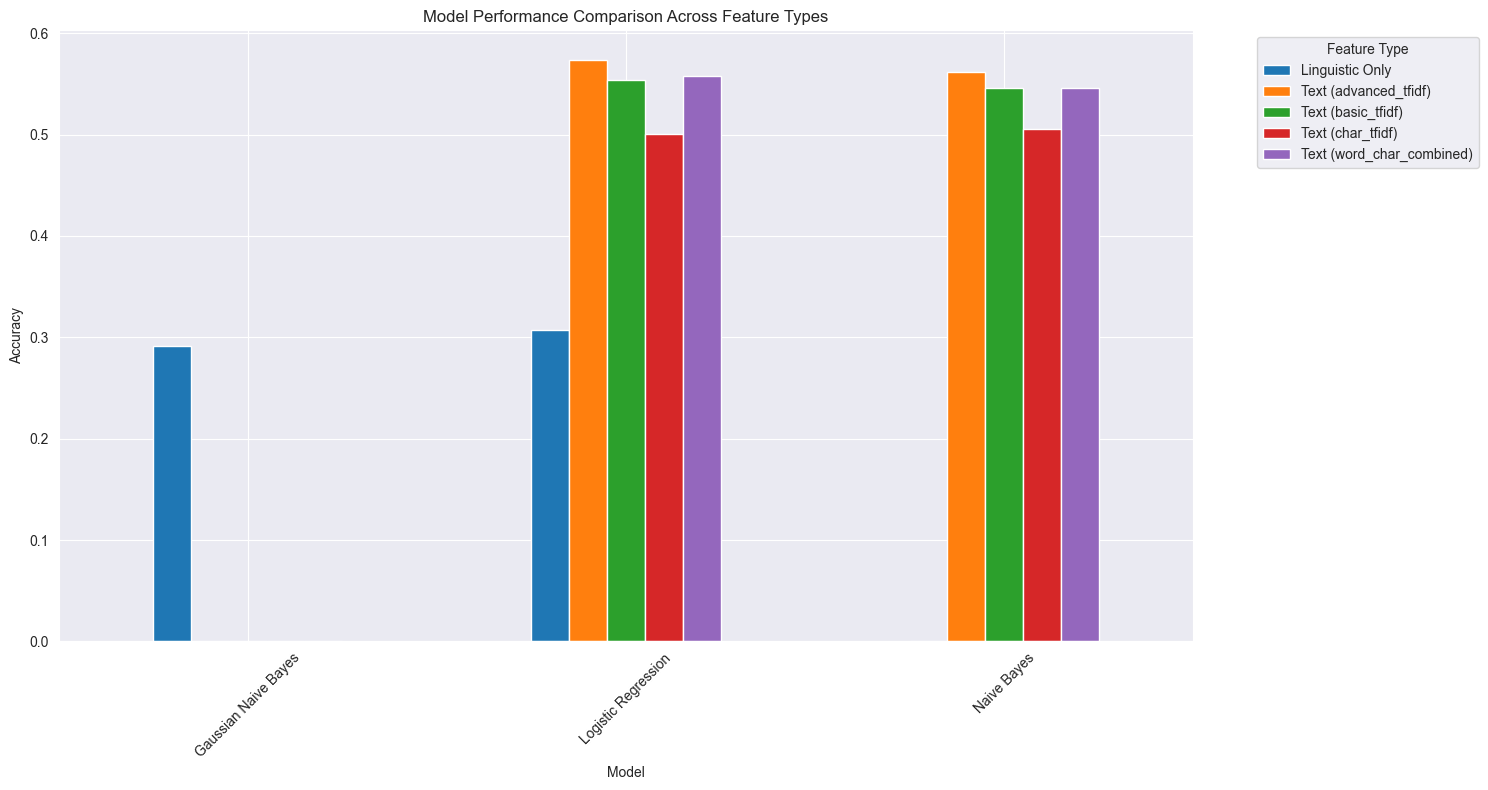

Detailed Results Comparison:
Feature_Type          Linguistic Only  Text (advanced_tfidf)  \
Model                                                          
Gaussian Naive Bayes           0.2916                    NaN   
Logistic Regression            0.3075                 0.5740   
Naive Bayes                       NaN                 0.5619   

Feature_Type          Text (basic_tfidf)  Text (char_tfidf)  \
Model                                                         
Gaussian Naive Bayes                 NaN                NaN   
Logistic Regression               0.5540             0.5001   
Naive Bayes                       0.5454             0.5053   

Feature_Type          Text (word_char_combined)  
Model                                            
Gaussian Naive Bayes                        NaN  
Logistic Regression                      0.5578  
Naive Bayes                              0.5454  

🏆 BEST OVERALL MODEL:
Feature Type: Text (advanced_tfidf)
Model: Logistic Regressio

In [16]:
# Create comparison dataframe
comparison_data = []

# Text-only results
for vec_name, vec_results in results_text_only.items():
    for model_name, model_results in vec_results.items():
        comparison_data.append({
            'Feature_Type': f'Text ({vec_name})',
            'Model': model_name,
            'Accuracy': model_results['accuracy']
        })

# Linguistic-only results
for model_name, model_results in results_linguistic_only.items():
    comparison_data.append({
        'Feature_Type': 'Linguistic Only',
        'Model': model_name,
        'Accuracy': model_results['accuracy']
    })

# Combined results
for model_name, model_results in results_combined.items():
    comparison_data.append({
        'Feature_Type': 'Combined',
        'Model': model_name,
        'Accuracy': model_results['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)

# Visualize results
plt.figure(figsize=(15, 8))
pivot_df = comparison_df.pivot(index='Model', columns='Feature_Type', values='Accuracy')
pivot_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison Across Feature Types')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='Feature Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("Detailed Results Comparison:")
print("="*50)
print(comparison_df.pivot(index='Model', columns='Feature_Type', values='Accuracy').round(4))

# Best overall model
best_overall = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n🏆 BEST OVERALL MODEL:")
print(f"Feature Type: {best_overall['Feature_Type']}")
print(f"Model: {best_overall['Model']}")
print(f"Accuracy: {best_overall['Accuracy']:.4f}")

In [17]:
# Feature importance for the best model
best_model_name = best_overall['Model']
best_feature_type = best_overall['Feature_Type']

print(f"Analyzing feature importance for: {best_model_name} with {best_feature_type}")

if 'Combined' in best_feature_type:
    # For combined model, analyze both text and linguistic features
    best_model_obj = results_combined[best_model_name]['model']

    if hasattr(best_model_obj, 'feature_importances_'):
        # For tree-based models
        importances = best_model_obj.feature_importances_

        # Text features importance
        text_importance = importances[:X_train_text_best.shape[1]]
        ling_importance = importances[X_train_text_best.shape[1]:]

        # Top text features
        vectorizer = text_features[best_vec_name]['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        text_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': text_importance
        }).sort_values('importance', ascending=False)

        print("Top 20 Text Features:")
        print(text_importance_df.head(20))

        # Linguistic features importance
        ling_importance_df = pd.DataFrame({
            'feature': linguistic_features_list,
            'importance': ling_importance
        }).sort_values('importance', ascending=False)

        print("\nLinguistic Features Importance:")
        print(ling_importance_df)

        # Visualize linguistic feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(ling_importance_df['feature'], ling_importance_df['importance'])
        plt.title('Linguistic Feature Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

elif hasattr(results_combined[best_model_name]['model'], 'coef_'):
    # For linear models, show coefficient analysis
    coefficients = results_combined[best_model_name]['model'].coef_
    print(f"Model coefficients shape: {coefficients.shape}")

    # This would require more complex analysis for multi-class classification
    print("Coefficient analysis available but requires class-specific interpretation")

# Cross-validation analysis of best model
from sklearn.model_selection import cross_val_score

print(f"\nCross-validation analysis for best model:")
cv_scores = cross_val_score(
    results_combined[best_model_name]['model'],
    X_train_combined,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

Analyzing feature importance for: Logistic Regression with Text (advanced_tfidf)


KeyError: 'Logistic Regression'

In [ ]:
# Detailed evaluation of the best model
best_predictions = None

if 'Combined' in best_feature_type:
    best_predictions = results_combined[best_model_name]['predictions']
elif 'Linguistic' in best_feature_type:
    best_predictions = results_linguistic_only[best_model_name]['predictions']
else:
    # Find the specific text model
    vec_name = best_feature_type.split('(')[1].split(')')[0]
    best_predictions = results_text_only[vec_name][best_model_name]['predictions']

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test, best_predictions))

# Error Analysis
print("\nError Analysis:")
errors_df = pd.DataFrame({
    'true_label': y_test.values,
    'predicted_label': best_predictions,
    'text_sample': X_text_test.values
})

errors_df['is_error'] = errors_df['true_label'] != errors_df['predicted_label']
errors = errors_df[errors_df['is_error']]

print(f"Total errors: {len(errors)}")
print(f"Error rate: {len(errors) / len(y_test):.4f}")

# Show error patterns
error_patterns = errors.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
print("\nError patterns (true_label -> predicted_label):")
print(error_patterns)

# Sample error cases
if len(errors) > 0:
    print("\nSample error cases:")
    for i, row in errors.head(3).iterrows():
        print(f"\nTrue: {row['true_label']}")
        print(f"Predicted: {row['predicted_label']}")
        print(f"Text sample: {row['text_sample'][:200]}...")

In [ ]:
# Summary of findings
print("🔍 MODEL PERFORMANCE SUMMARY")
print("="*50)

# Performance by feature type
feature_performance = comparison_df.groupby('Feature_Type')['Accuracy'].agg(['mean', 'std', 'max'])
print("Average performance by feature type:")
print(feature_performance.round(4))

print(f"\n🏆 BEST MODEL CONFIGURATION:")
print(f"Feature Type: {best_overall['Feature_Type']}")
print(f"Algorithm: {best_overall['Model']}")
print(f"Test Accuracy: {best_overall['Accuracy']:.4f}")

# Key insights
print(f"\n📊 KEY INSIGHTS:")
print("="*30)

# 1. Feature type effectiveness
text_only_max = comparison_df[comparison_df['Feature_Type'].str.contains('Text')]['Accuracy'].max()
ling_only_max = comparison_df[comparison_df['Feature_Type'] == 'Linguistic Only']['Accuracy'].max()
combined_max = comparison_df[comparison_df['Feature_Type'] == 'Combined']['Accuracy'].max()

print(f"1. Feature Type Effectiveness:")
print(f"   • Text features only: {text_only_max:.4f}")
print(f"   • Linguistic features only: {ling_only_max:.4f}")
print(f"   • Combined features: {combined_max:.4f}")

improvement = combined_max - max(text_only_max, ling_only_max)
if improvement > 0:
    print(f"   ✓ Combined approach improves accuracy by {improvement:.4f}")
else:
    print(f"   ⚠ Combined approach shows {abs(improvement):.4f} decrease")

# 2. Algorithm performance
algo_performance = comparison_df.groupby('Model')['Accuracy'].agg(['mean', 'max'])
print(f"\n2. Algorithm Performance (average across all feature types):")
for algo, perf in algo_performance.iterrows():
    print(f"   • {algo}: avg={perf['mean']:.4f}, max={perf['max']:.4f}")

# 3. Model complexity vs performance
print(f"\n3. Recommendations:")
print("   Based on the results:")
if combined_max > max(text_only_max, ling_only_max):
    print("   ✓ Use combined text + linguistic features for best performance")
    print("   ✓ Linguistic features provide valuable additional signal")
else:
    print("   ⚠ Simple text-only features may be sufficient")
    print("   ⚠ Consider model complexity vs. marginal gains")

if 'Random Forest' in comparison_df['Model'].values:
    rf_performance = comparison_df[comparison_df['Model'] == 'Random Forest']['Accuracy'].max()
    print(f"   • Random Forest provides interpretable feature importance")

if 'Logistic Regression' in comparison_df['Model'].values:
    lr_performance = comparison_df[comparison_df['Model'] == 'Logistic Regression']['Accuracy'].max()
    print(f"   • Logistic Regression offers good balance of performance and interpretability")

print(f"\n💡 PRACTICAL APPLICATIONS:")
print("="*35)
print("This model could be used for:")
print("• Automatic profile categorization")
print("• Content recommendation systems")
print("• Educational background inference")
print("• Writing style analysis")
print("• Market research and user segmentation")

print(f"\n⚠ LIMITATIONS & CONSIDERATIONS:")
print("="*40)
print("• Dataset size is limited - results may vary with larger datasets")
print("• Education categories are self-reported and may have inconsistencies")
print("• Text style varies significantly between individuals")
print("• Model may be biased toward certain writing patterns")
print("• Cross-validation scores should be considered for robustness")

# Save results summary
results_summary = {
    'best_model': {
        'feature_type': best_overall['Feature_Type'],
        'algorithm': best_overall['Model'],
        'accuracy': best_overall['Accuracy']
    },
    'feature_comparison': {
        'text_only_max': text_only_max,
        'linguistic_only_max': ling_only_max,
        'combined_max': combined_max
    },
    'algorithm_comparison': algo_performance.to_dict()
}

print(f"\n💾 Results summary saved to 'results_summary' variable")
print("Use this data for further analysis or reporting")

In [ ]:
# Save the best model and vectorizer for future use
import pickle

# Determine which model and features to save
if 'Combined' in best_feature_type:
    model_to_save = results_combined[best_model_name]['model']
    vectorizer_to_save = text_features[best_vec_name]['vectorizer']
    scaler_to_save = scaler

    print("Saving combined model components...")

    # Save model
    with open('best_education_classifier_model.pkl', 'wb') as f:
        pickle.dump(model_to_save, f)

    # Save vectorizer
    with open('best_text_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer_to_save, f)

    # Save scaler
    with open('linguistic_features_scaler.pkl', 'wb') as f:
        pickle.dump(scaler_to_save, f)

    print("✓ Saved: best_education_classifier_model.pkl")
    print("✓ Saved: best_text_vectorizer.pkl")
    print("✓ Saved: linguistic_features_scaler.pkl")

# Create a prediction function for new data
def predict_education_level(essay_text):
    """
    Predict education level for new essay text.

    Args:
        essay_text (str): The essay text to classify

    Returns:
        str: Predicted education level
    """
    if 'Combined' in best_feature_type:
        # Load saved components (in practice, you'd load from files)
        model = results_combined[best_model_name]['model']
        vectorizer = text_features[best_vec_name]['vectorizer']

        # Process text
        processed_text = advanced_preprocess(essay_text)

        # Extract linguistic features
        ling_features = extract_linguistic_features(essay_text)
        ling_features_array = np.array([list(ling_features.values())])
        ling_features_scaled = scaler.transform(ling_features_array)

        # Vectorize text
        text_features_vec = vectorizer.transform([processed_text])

        # Combine features
        combined_features = hstack([text_features_vec, ling_features_scaled])

        # Predict
        prediction = model.predict(combined_features)[0]
        probability = model.predict_proba(combined_features)[0]

        return prediction, probability
    else:
        print("Prediction function requires combined model setup")
        return None, None

# Test the prediction function with a sample
if len(df_clean) > 0:
    sample_text = df_clean.iloc[0]['combined_essays']
    sample_true_label = df_clean.iloc[0]['education']

    pred, prob = predict_education_level(sample_text)
    if pred is not None:
        print(f"\nSample Prediction Test:")
        print(f"True label: {sample_true_label}")
        print(f"Predicted: {pred}")
        print(f"Confidence: {max(prob):.4f}")
        print(f"All probabilities: {dict(zip(model_to_save.classes_, prob))}")

print(f"\n🎉 PROJECT COMPLETED!")
print("="*30)
print("You now have a complete education level classification system!")
print("Next steps could include:")
print("• Testing with a larger dataset")
print("• Hyperparameter tuning")
print("• Feature engineering improvements")
print("• Deployment as a web service")
print("• A/B testing different approaches")

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

print("SIMPLE TRANSFORMER CLASSIFICATION")
print("=" * 40)

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Create label mapping
unique_labels = sorted(df_clean['education_classified'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
num_classes = len(unique_labels)

print(f"Classes: {unique_labels}")
print(f"Number of classes: {num_classes}")

# Use existing train/test split from earlier cells
train_texts = X_text_train.tolist()
test_texts = X_text_test.tolist()
train_labels = [label2id[label] for label in y_train]
test_labels = [label2id[label] for label in y_test]

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")

# Simple Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Simple transformer classifier
class SimpleTransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

        # Use last_hidden_state and pool it manually for DistilBERT
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

        # Mean pooling across sequence length
        pooled_output = torch.mean(last_hidden_state, dim=1)  # Shape: (batch_size, hidden_size)

        output = self.dropout(pooled_output)
        return self.classifier(output)

# Initialize model and tokenizer
model_name = "distilbert-base-uncased"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = SimpleTransformerClassifier(model_name, num_classes).to(device)

# Create datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    return total_loss / len(data_loader), correct_predictions / total_predictions

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Training loop
num_epochs = 2
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Evaluate on test set
    predictions, true_labels = evaluate(model, test_loader, device)
    test_accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Final evaluation
print("\nFinal Evaluation:")
predictions, true_labels = evaluate(model, test_loader, device)

# Convert back to label names
pred_label_names = [id2label[pred] for pred in predictions]
true_label_names = [id2label[true] for true in true_labels]

# Calculate metrics
final_accuracy = accuracy_score(true_labels, predictions)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(true_label_names, pred_label_names))

# Compare with best classical ML result
print(f"\nPERFORMANCE COMPARISON:")
print("=" * 30)
print(f"Best Classical ML: {best_combined_accuracy:.4f}")
print(f"Simple Transformer: {final_accuracy:.4f}")
improvement = final_accuracy - best_combined_accuracy
print(f"Improvement: {improvement:+.4f} ({improvement/best_combined_accuracy*100:+.1f}%)")

if final_accuracy > best_combined_accuracy:
    print("Transformer wins!")
else:
    print("Classical ML still competitive!")

print(f"\nTransformer training complete!")


SIMPLE TRANSFORMER CLASSIFICATION
Using device: mps
Classes: ['College Graduate', 'Graduate/Professional', 'High School Level', 'Some College']
Number of classes: 4
Training samples: 39764
Test samples: 9941
Loading distilbert-base-uncased...
Starting training for 2 epochs...

Epoch 1/2


Training: 100%|██████████| 4971/4971 [11:30:06<00:00,  8.33s/it]     


Train Loss: 0.9206, Train Acc: 0.5930


Evaluating: 100%|██████████| 1243/1243 [1:16:10<00:00,  3.68s/it]    


Test Accuracy: 0.6485

Epoch 2/2


Training: 100%|██████████| 4971/4971 [2:12:56<00:00,  1.60s/it]  


Train Loss: 0.7611, Train Acc: 0.6738


Evaluating: 100%|██████████| 1243/1243 [06:50<00:00,  3.03it/s]


Test Accuracy: 0.6482

Final Evaluation:


Evaluating: 100%|██████████| 1243/1243 [06:51<00:00,  3.02it/s]


Final Test Accuracy: 0.6482

Detailed Classification Report:
                       precision    recall  f1-score   support

     College Graduate       0.60      0.92      0.73      4776
Graduate/Professional       0.82      0.37      0.51      2988
    High School Level       0.41      0.17      0.24       314
         Some College       0.75      0.49      0.59      1863

             accuracy                           0.65      9941
            macro avg       0.64      0.49      0.52      9941
         weighted avg       0.69      0.65      0.62      9941


PERFORMANCE COMPARISON:


NameError: name 'best_combined_accuracy' is not defined